## Ref 

- https://medium.com/machine-learning-world/neural-networks-for-algorithmic-trading-part-one-simple-time-series-forecasting-f992daa1045a

- https://github.com/Rachnog/Deep-Trading/tree/master/simple_forecasting


### Modify from 
-https://github.com/Rachnog/Deep-Trading/tree/master/simple_forecasting

In [16]:
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback

In [17]:
# help function 
# --------- processing  --------- #


def load_snp_returns():
    f = open('table.csv', 'rb').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            open_price = float(line.split(',')[1])
            close_price = float(line.split(',')[4])
            raw_data.append(close_price - open_price)
            raw_dates.append(line.split(',')[0])
        except:
            continue

    return raw_data[::-1], raw_dates[::-1]



def load_snp_close():
    # fix here for python 3 
    f = open('table.csv', 'rb').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            # fix here for python 3 
            # fix string split 
            close_price =  float(str(line).split(',')[4])
            raw_data.append(close_price)
            # fix here for python 3 
            # fix string split 
            raw_dates.append(str(line).split(',')[0].strip("b'"))
        except:
            continue

    return raw_data, raw_dates




def split_into_chunks(data, train, predict, step, binary=True, scale=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]
            
            # Use it only for daily return time series
            if binary:
                if y_i > 0.:
                    y_i = [1., 0.]
                else:
                    y_i = [0., 1.]

                if scale: x_i = preprocessing.scale(x_i)
                
            else:
                timeseries = np.array(data[i:i+train+predict])
                if scale: timeseries = preprocessing.scale(timeseries)
                x_i = timeseries[:-1]
                y_i = timeseries[-1]
            
        except:
            break

        X.append(x_i)
        Y.append(y_i)

    return X, Y


def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


def create_Xt_Yt(X, y, percentage=0.8):
    # fix here for python 3 
    # make sure index is integer
    # i.e. 3.44 -> 3 
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
    # make sure index is integer
    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]

    return X_train, X_test, Y_train, Y_test


In [18]:
# help function 

# --------- processing  --------- #



class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
        self.predictions = []
        self.i = 0
        self.save_every = 5000

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        self.i += 1        
        if self.i % self.save_every == 0:        
            pred = model.predict(X_train)
            self.predictions.append(pred)


In [19]:
#cd analysis/z_demand_predict/ref/time_series/

Data loading...
Building model...


/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 13513 samples, validate on 1502 samples
Epoch 1/5
13513/13513 [==============================] - 1s 92us/step - loss: 0.3133 - val_loss: 0.0886
Epoch 2/5
13513/13513 [==============================] - 1s 55us/step - loss: 0.0739 - val_loss: 0.0128
Epoch 3/5
13513/13513 [==============================] - 1s 57us/step - loss: 0.0414 - val_loss: 0.0127
Epoch 4/5
13513/13513 [==============================] - 1s 57us/step - loss: 0.0284 - val_loss: 0.0068
Epoch 5/5
1669/1669 [==============================] - 0s 24us/step
0.004834429775668813
938.1089


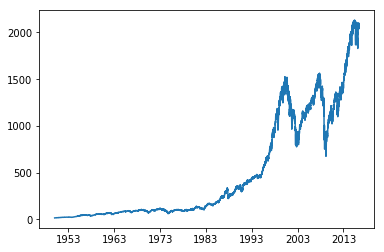

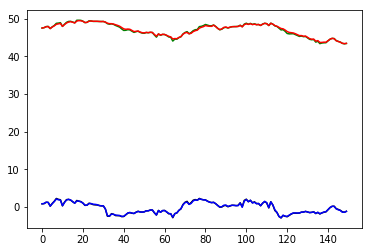

In [27]:
# --------- train  --------- #
 

TRAIN_SIZE = 30
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

print ('Data loading...') 
timeseries, dates = load_snp_close()
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(dates, timeseries)

TRAIN_SIZE = 20
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Xp, Yp = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = create_Xt_Yt(Xp, Yp, percentage=0.9)


print ('Building model...')
model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', 
              loss='mse')

model.fit(X_train, 
          Y_train, 
          nb_epoch=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)
score = model.evaluate(X_test, Y_test, batch_size=128)
print (score)


params = []
for xt in X_testp:
    xt = np.array(xt)
    mean_ = xt.mean()
    scale_ = xt.std()
    params.append([mean_, scale_])

predicted = model.predict(X_test)
new_predicted = []

for pred, par in zip(predicted, params):
    a = pred*par[1]
    a += par[0]
    new_predicted.append(a)
    

mse = mean_squared_error(predicted, new_predicted)
print (mse)

try:
    fig = plt.figure()
    plt.plot(Y_test[:150], color='black') # BLUE - trained RESULT
    plt.plot(predicted[:150], color='blue') # RED - trained PREDICTION
    plt.plot(Y_testp[:150], color='green') # GREEN - actual RESULT
    plt.plot(new_predicted[:150], color='red') # ORANGE - restored PREDICTION
    plt.show()
except Exception as e:
    print (str(e))